**about the data:**

The Chest X-Ray dataset (from the Kaggle Pneumonia dataset) contains thousands of frontal-view chest X-ray images labeled as either NORMAL or PNEUMONIA. The data helps train deep learning models to detect lung infections, especially useful in automated diagnostic tools. One of the most used versions contains around 5,863 images split into training, validation, and test sets.

##To run on your Drive:##
1. Open the link https://drive.google.com/drive/folders/1Vua6DJqwfKXW4wS8gPBENFjAy6Ug4vPW?usp=sharing
2. Add a shortcut to MyDrive on your personal Drive
3. Run the notebook

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import shutil

# Define paths
source_dir = "/content/gdrive/MyDrive/RSNA"  # Update with your actual path

# Output path: current directory
output_dir = "./RSNA_dataset"

# Number of images per class for each set
split_counts = {
    'Training': 80,
    'Validation': 40,
    'Testing': 40
}

# Target classes
classes = ["NORMAL", "PNEUMONIA"]

def is_image_file(filename):
    return filename.lower().endswith(('.jpg', '.jpeg', '.png'))

def prepare_split_data():
    # Create split folders
    for split in split_counts:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    for cls in classes:
        class_path = os.path.join(source_dir, cls)
        all_images = [f for f in os.listdir(class_path) if is_image_file(f)]
        random.shuffle(all_images)

        total_needed = sum(split_counts.values())
        selected_images = all_images[:total_needed]

        start = 0
        for split, count in split_counts.items():
            split_images = selected_images[start:start+count]
            for img in split_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(output_dir, split, cls, img)
                try:
                    shutil.copyfile(src, dst)
                except Exception as e:
                    print(f"⚠️ Skipping {img} due to error: {e}")
            start += count

    print("\n✅ Dataset split complete.")
    print(f"Split folders created inside: {os.path.abspath(output_dir)}")

# Run
prepare_split_data()



✅ Dataset split complete.
Split folders created inside: /content/RSNA_dataset


In [ ]:
%cd "/content/RSNA_dataset"

/content/RSNA_dataset


In [ ]:
!ls

Testing  Training  Validation


Found 160 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Loaded 160 images.
Loaded 80 images.
Loaded 80 images.


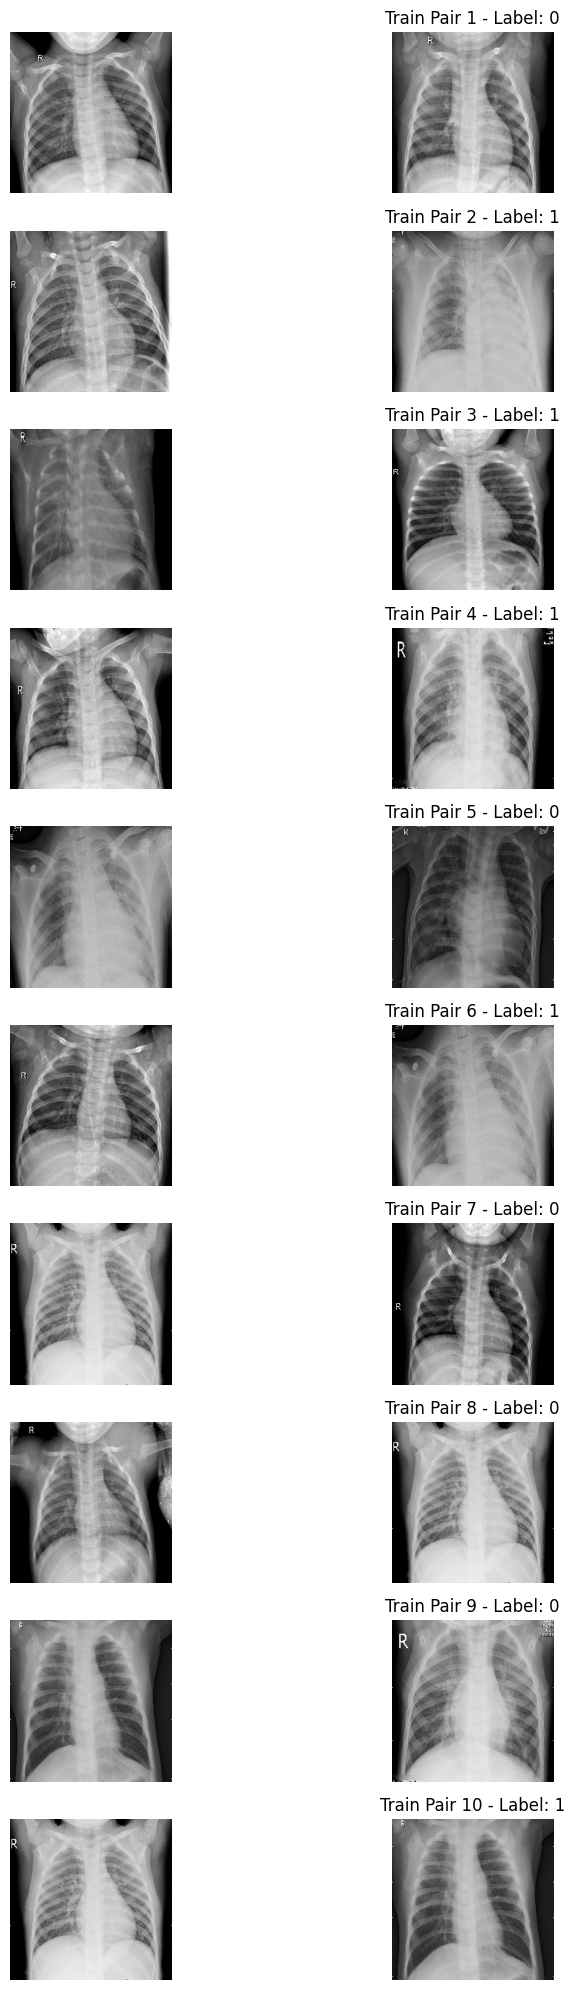

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class SiamesePairGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_generator, batch_size=16):
        self.batch_size = batch_size
        self.base_generator = base_generator
        self.x, self.y = self._load_data()
        self.label_to_indices = {label: np.where(self.y == label)[0] for label in np.unique(self.y)}

    def _load_data(self):
        x, y = [], []
        self.base_generator.reset()
        for _ in range(len(self.base_generator)):
            xi, yi = next(self.base_generator)
            x.append(xi)
            y.append(yi)
        x = np.concatenate(x)
        y = np.concatenate(y)
        print(f"Loaded {len(x)} images.")
        return x, y

    def __len__(self):
        return max(1, len(self.x) // self.batch_size)

    def __getitem__(self, idx):
        left, right, labels = [], [], []

        for _ in range(self.batch_size):
            if np.random.rand() < 0.5:
                cls = np.random.choice(list(self.label_to_indices.keys()))
                i1, i2 = np.random.choice(self.label_to_indices[cls], 2, replace=False)
                labels.append(0)
            else:
                cls1, cls2 = np.random.choice(list(self.label_to_indices.keys()), 2, replace=False)
                i1 = np.random.choice(self.label_to_indices[cls1])
                i2 = np.random.choice(self.label_to_indices[cls2])
                labels.append(1)
            left.append(self.x[i1])
            right.append(self.x[i2])

        return (np.array(left), np.array(right)), np.array(labels)

def visualize(p1, p2, labels, title):
    plt.figure(figsize=(10, 20))
    for i in range(10):
        plt.subplot(10, 2, 2*i+1)
        plt.imshow(p1[i]); plt.axis('off')
        plt.subplot(10, 2, 2*i+2)
        plt.imshow(p2[i]); plt.axis('off')
        plt.title(f'{title} Pair {i+1} - Label: {labels[i]}')
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    train_dir = './Training'  # <-- must have subfolders per class!
    val_dir = './Validation'
    test_dir = './Testing'

    datagen = ImageDataGenerator(rescale=1./255)
    img_size = (224, 224)

    base_train = datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=50, class_mode='binary', shuffle=True)
    base_val = datagen.flow_from_directory(
        val_dir, target_size=img_size, batch_size=50, class_mode='binary', shuffle=False)
    base_test = datagen.flow_from_directory(
        test_dir, target_size=img_size, batch_size=50, class_mode='binary', shuffle=False)

    train_gen = SiamesePairGenerator(base_train, batch_size=32)
    val_gen = SiamesePairGenerator(base_val, batch_size=32)
    test_gen= SiamesePairGenerator(base_test, batch_size=32)

    # Test: fetch first batch
    (x1, x2), y = train_gen[0]
    visualize(x1, x2, y, title='Train')

Loaded 160 images.
Loaded 80 images.


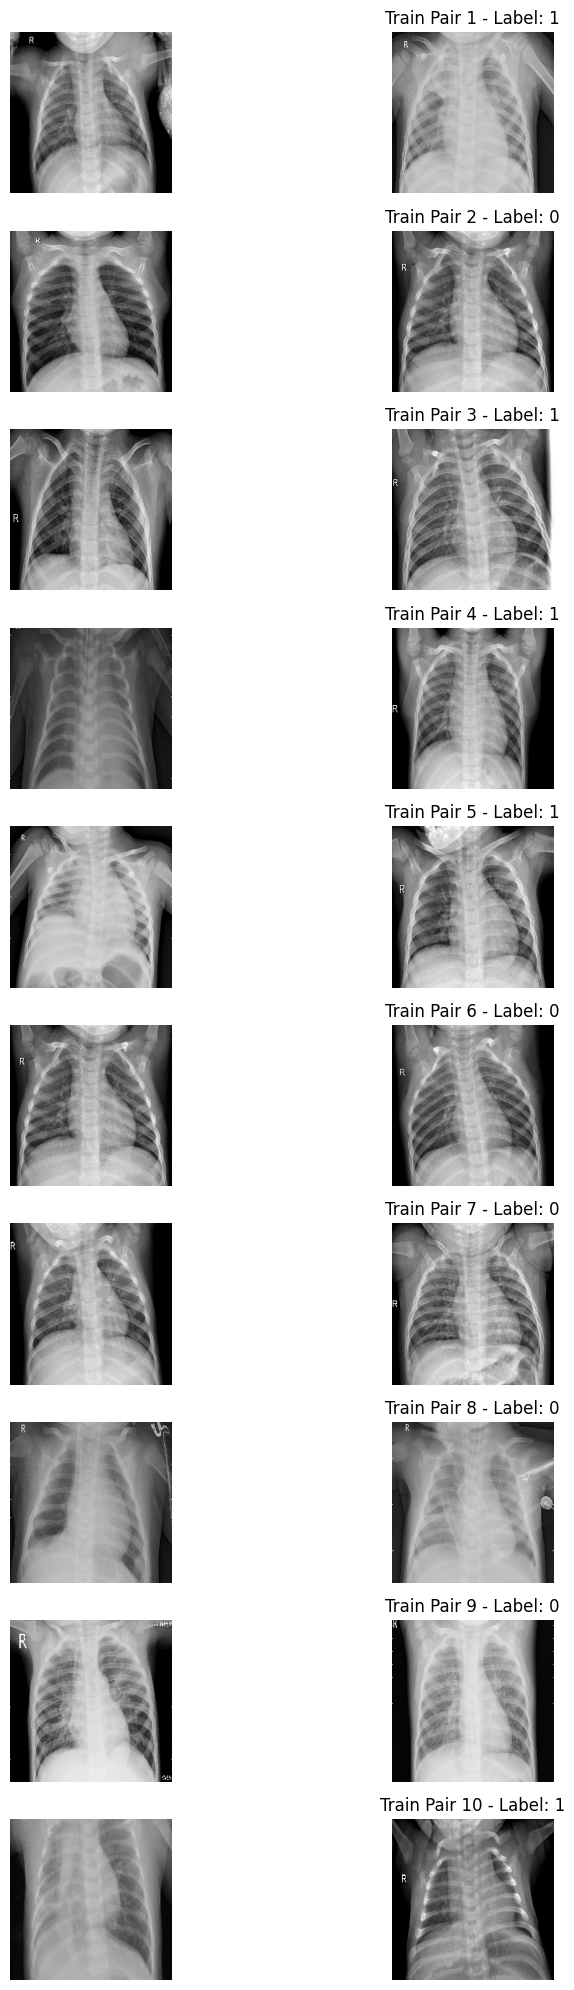

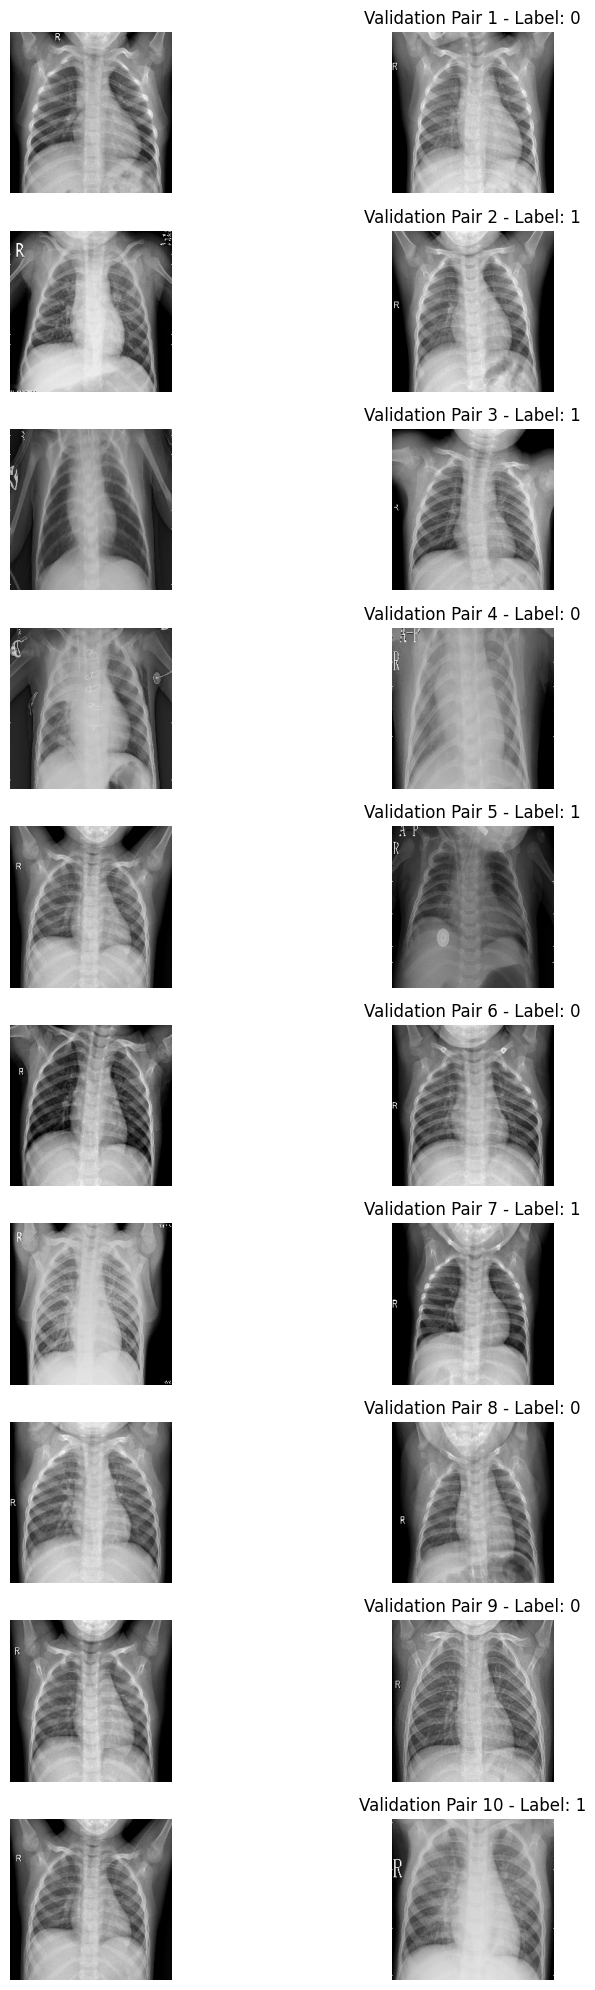

In [ ]:
train_gen = SiamesePairGenerator(base_train, batch_size=16)
val_gen = SiamesePairGenerator(base_val, batch_size=16)


    # Example usage: one batch
(train_left, train_right), train_labels = train_gen[0]
(val_left, val_right), val_labels = val_gen[0]

    # Visualize 10 training and validation pairs
visualize(train_left, train_right, train_labels, title='Train')
visualize(val_left, val_right, val_labels, title='Validation')

In [ ]:
# Define a Siamese network with DenseNet121 as the base model
def build_siamese_network(input_shape):
    # Load pre-trained DenseNet121 with ImageNet weights
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the pre-trained layers except for the last 20 layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Add custom layers on top of DenseNet121
    input = keras.layers.Input(input_shape)
    x = base_model(input)

    # Global pooling to reduce dimensions
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Additional dense layers for feature extraction
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.53)(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    return keras.Model(input, x)

# Define contrastive loss function
def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return loss

# Euclidean Distance Function
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

def compute_contrastive_accuracy(y_true, y_pred, threshold=0.5):
    return tf.keras.metrics.binary_accuracy(y_true, tf.cast(y_pred > threshold, tf.float32))


# Create the Siamese model using DenseNet121
input_shape = (224, 224, 3)  # Standard input size for DenseNet121
embedding_network = build_siamese_network(input_shape)

input_1 = keras.layers.Input(input_shape)
input_2 = keras.layers.Input(input_shape)

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese_network = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

siamese_network.compile(loss=contrastive_loss(margin=1.5), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[compute_contrastive_accuracy])
siamese_network.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  7,630,016 │ input_layer_2[0]… │
│ (Functional)        │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,630,022 (29.11 MB)

 Trainable params: 958,660 (3.66 MB)

 Non-trainable params: 6,671,362 (25.45 MB)

In [ ]:
# Callback to log distances in the desired format
class DistanceLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_generator, num_batches=None):
        """
        Initialize with a validation generator instead of raw data

        Args:
            validation_generator: The validation data generator
            num_batches: Number of batches to use for validation (default: all)
        """
        super().__init__()
        self.validation_generator = validation_generator
        self.num_batches = num_batches if num_batches is not None else len(validation_generator)

    def on_epoch_end(self, epoch, logs=None):
        # Initialize arrays to store predictions and labels
        all_distances = []
        all_labels = []

        # Collect predictions from validation generator
        for i in range(min(self.num_batches, len(self.validation_generator))):
            # Get batch from generator
            (x1_batch, x2_batch), y_batch = self.validation_generator[i]

            # Get distances for this batch
            distances = self.model.predict([x1_batch, x2_batch], verbose=0)

            # Append to our collections
            all_distances.extend(distances)
            all_labels.extend(y_batch)

        # Convert to numpy arrays
        all_distances = np.array(all_distances).flatten()
        all_labels = np.array(all_labels)

        # Calculate metrics (remember: 0=same class, 1=different class)
        val_pos_dist = all_distances[all_labels == 0].mean()
        val_neg_dist = all_distances[all_labels == 1].mean()
        distance_gap = val_neg_dist - val_pos_dist

        # Print in the desired format
        print(f"Validation Set - Avg distance (same): {val_pos_dist:.4f}")
        print(f"Validation Set - Avg distance (diff): {val_neg_dist:.4f}")
        print(f"Distance gap: {distance_gap:.4f}")

        # Save metrics for later visualization
        if not hasattr(self, 'history'):
            self.history = {
                'val_pos_dist': [],
                'val_neg_dist': [],
                'distance_gap': []
            }

        self.history['val_pos_dist'].append(val_pos_dist)
        self.history['val_neg_dist'].append(val_neg_dist)
        self.history['distance_gap'].append(distance_gap)


# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import Callback

class EmbeddingVisualizer(Callback):
    """
    Callback to visualize the embedding space after each epoch using data from a generator.
    """
    def __init__(self, validation_generator, embedding_network, num_samples=500, class_names=None):
        """
        Initialize the visualizer with a validation generator.

        Args:
            validation_generator: SiamesePairGenerator to get validation samples from
            embedding_network: Model that extracts embeddings
            num_samples: Maximum number of samples to plot
            class_names: List of class names (from base_generator.class_indices)
        """
        super().__init__()
        self.validation_generator = validation_generator
        self.embedding_network = embedding_network
        self.num_samples = min(num_samples, len(validation_generator) * validation_generator.batch_size)
        self.class_names = class_names

        # For collecting history
        self.embeddings_history = []
        self.figures = []

        # Cache data for visualization
        self.cached_data = self._cache_data()

    def _cache_data(self):
        """Cache a subset of the validation data for visualization"""
        x1_samples, x2_samples, labels = [], [], []
        samples_collected = 0
        batch_index = 0

        # Collect samples until we reach desired number
        while samples_collected < self.num_samples and batch_index < len(self.validation_generator):
            # Get batch from generator
            (x1_batch, x2_batch), y_batch = self.validation_generator[batch_index]

            # Determine how many samples to take from this batch
            samples_to_take = min(len(y_batch), self.num_samples - samples_collected)

            # Add samples to our collections
            x1_samples.append(x1_batch[:samples_to_take])
            x2_samples.append(x2_batch[:samples_to_take])
            labels.append(y_batch[:samples_to_take])

            # Update counters
            samples_collected += samples_to_take
            batch_index += 1

        # Combine all batches
        x1_all = np.vstack(x1_samples)
        x2_all = np.vstack(x2_samples)
        labels_all = np.concatenate(labels)

        print(f"Cached {len(labels_all)} samples for embedding visualization")
        return x1_all, x2_all, labels_all

    def on_epoch_end(self, epoch, logs=None):
        # Get cached data
        x1_all, x2_all, labels_all = self.cached_data

        # Extract embeddings using the embedding network
        embeddings_1 = self.embedding_network.predict(x1_all, verbose=0)
        embeddings_2 = self.embedding_network.predict(x2_all, verbose=0)

        # Apply PCA to reduce dimensions for visualization
        combined = np.vstack([embeddings_1, embeddings_2])
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(combined)

        # Split back into pairs
        reduced_1 = reduced[:len(embeddings_1)]
        reduced_2 = reduced[len(embeddings_1):]

        # Store embeddings for later analysis
        self.embeddings_history.append((reduced_1, reduced_2))

        # Create figure
        fig = plt.figure(figsize=(10, 8))

        # Get indices of same/different pairs
        same_indices = np.where(labels_all == 0)[0]
        diff_indices = np.where(labels_all == 1)[0]

        # Draw lines for same-category pairs (green)
        max_lines = min(50, len(same_indices))
        for i in same_indices[:max_lines]:
            plt.plot([reduced_1[i, 0], reduced_2[i, 0]],
                    [reduced_1[i, 1], reduced_2[i, 1]],
                    'g-', alpha=0.3)

        # Draw lines for different-category pairs (red)
        max_lines = min(50, len(diff_indices))
        for i in diff_indices[:max_lines]:
            plt.plot([reduced_1[i, 0], reduced_2[i, 0]],
                    [reduced_1[i, 1], reduced_2[i, 1]],
                    'r-', alpha=0.3)

        # Plot the points
        plt.scatter(reduced_1[:, 0], reduced_1[:, 1], alpha=0.6, label='Image 1')
        plt.scatter(reduced_2[:, 0], reduced_2[:, 1], alpha=0.6, label='Image 2')

        # Add grid and labels
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title(f'CHEST-X_REST Embedding Space - Epoch {epoch+1}')
        plt.xlabel('Embedding Dimension 1')
        plt.ylabel('Embedding Dimension 2')

        # Add legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color='g', lw=2, label='Same Category'),
            Line2D([0], [0], color='r', lw=2, label='Different Category'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='C0', markersize=8, label='Image 1'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='C1', markersize=8, label='Image 2')
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        # Save figure
        self.figures.append(fig)

        # Display the plot
        plt.show()
        plt.close()

In [ ]:
# Create the callbacks
distance_logger = DistanceLogger(validation_generator=val_gen)
embedding_visualizer = EmbeddingVisualizer(
    validation_generator=val_gen,
    embedding_network=embedding_network,  # This should be the base network that extracts embeddings
    num_samples=200,
    class_names=list(base_train.class_indices.keys())  # Get class names from the base generator
)

# Create your other callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('siamese_model.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    distance_logger,
    embedding_visualizer
]

Cached 80 samples for embedding visualization


In [ ]:
""" if you want to save the model:
gdrive_save_path = '/content/gdrive/MyDrive/mini_project_shira_and_tzfiya/chest/siamese_model_best.keras' # Changed to .keras
final_gdrive_save_path = '/content/gdrive/MyDrive/mini_project_shira_and_tzfiya/chest/siamese_model_final.keras' # Changed to .keras


import os

gdrive_folder = os.path.dirname(gdrive_save_path)
os.makedirs(gdrive_folder, exist_ok=True)
print(f"Saving models to: {gdrive_folder}")

# Create the callbacks
distance_logger = DistanceLogger(validation_generator=val_gen)
embedding_visualizer = EmbeddingVisualizer(
    validation_generator=val_gen,
    embedding_network=embedding_network,  # This should be the base network that extracts embeddings
    num_samples=200,
    class_names=list(base_train.class_indices.keys())  # Get class names from the base generator
)

# Create your other callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=gdrive_save_path,  # Save to Google Drive
        save_best_only=True,
        monitor='val_loss',  # Monitor validation loss
        mode='min',          # Save when validation loss decreases
        verbose=1
    ),
    EarlyStopping(patience=5, restore_best_weights=True),
    distance_logger,
    embedding_visualizer
]
"""

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - compute_contrastive_accuracy: 0.4783 - loss: 0.6765

Validation Set - Avg distance (same): 0.7167
Validation Set - Avg distance (diff): 0.8022
Distance gap: 0.0855


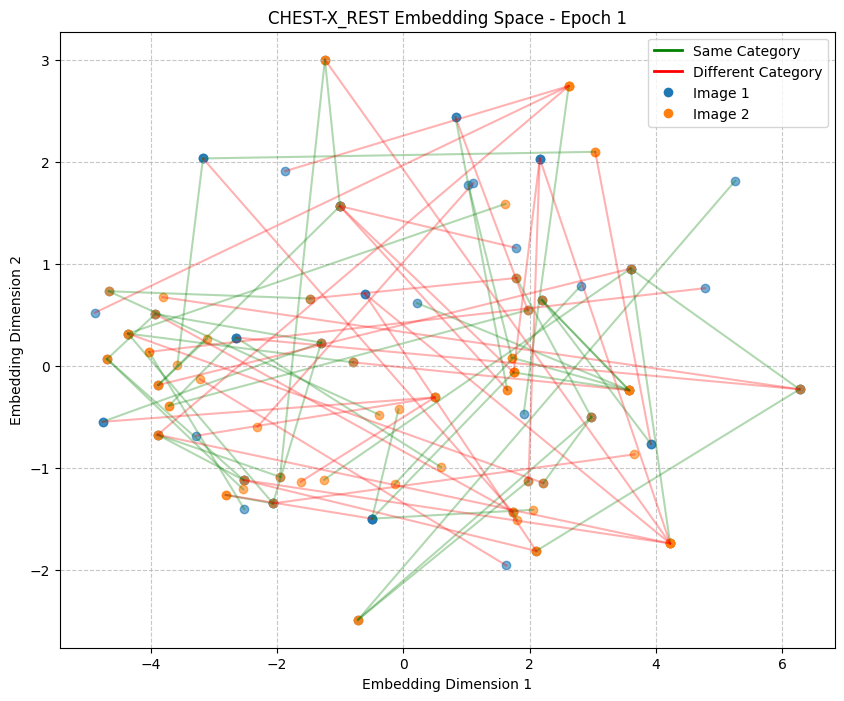

10/10 ━━━━━━━━━━━━━━━━━━━━ 133s 9s/step - compute_contrastive_accuracy: 0.4803 - loss: 0.6726 - val_compute_contrastive_accuracy: 0.5250 - val_loss: 0.5313
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - compute_contrastive_accuracy: 0.6621 - loss: 0.5350

Validation Set - Avg distance (same): 0.6887
Validation Set - Avg distance (diff): 0.7955
Distance gap: 0.1068


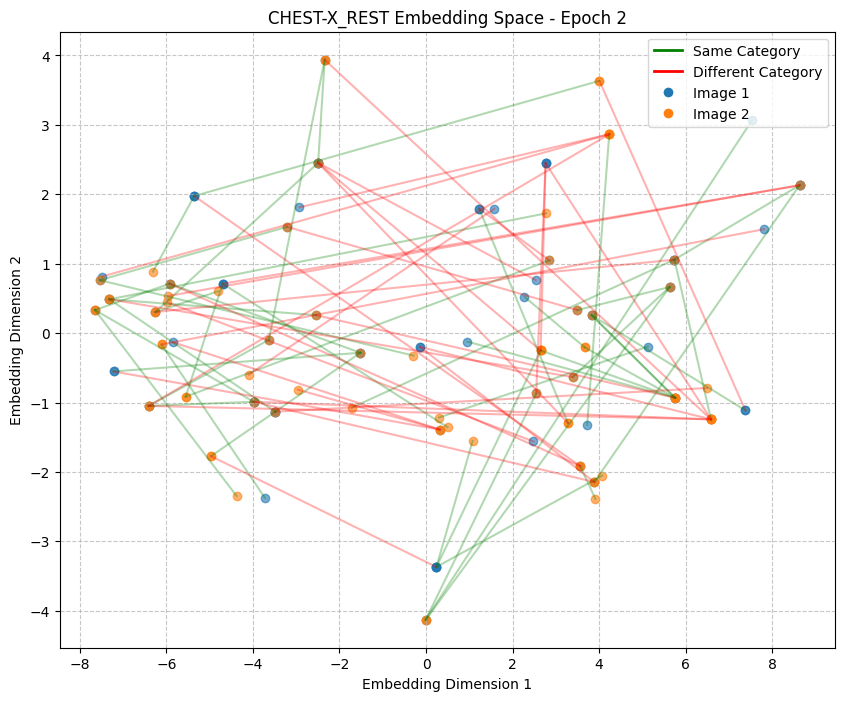

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 785ms/step - compute_contrastive_accuracy: 0.6621 - loss: 0.5355 - val_compute_contrastive_accuracy: 0.4375 - val_loss: 0.4791
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - compute_contrastive_accuracy: 0.6352 - loss: 0.5624

Validation Set - Avg distance (same): 0.6244
Validation Set - Avg distance (diff): 0.7685
Distance gap: 0.1441


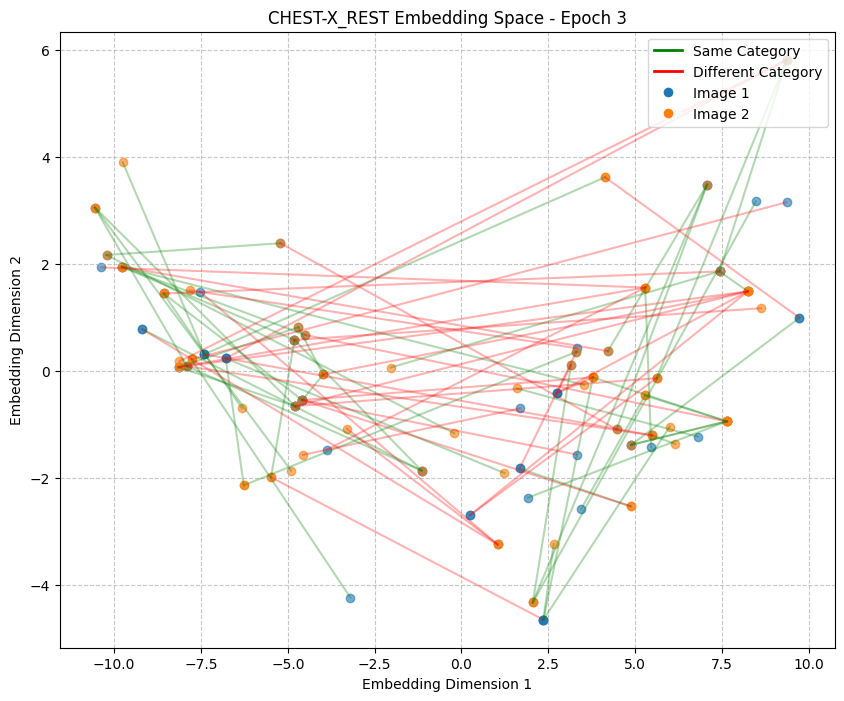

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 785ms/step - compute_contrastive_accuracy: 0.6348 - loss: 0.5613 - val_compute_contrastive_accuracy: 0.6000 - val_loss: 0.4671
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - compute_contrastive_accuracy: 0.6456 - loss: 0.5553Validation Set - Avg distance (same): 0.6135
Validation Set - Avg distance (diff): 0.7426
Distance gap: 0.1291


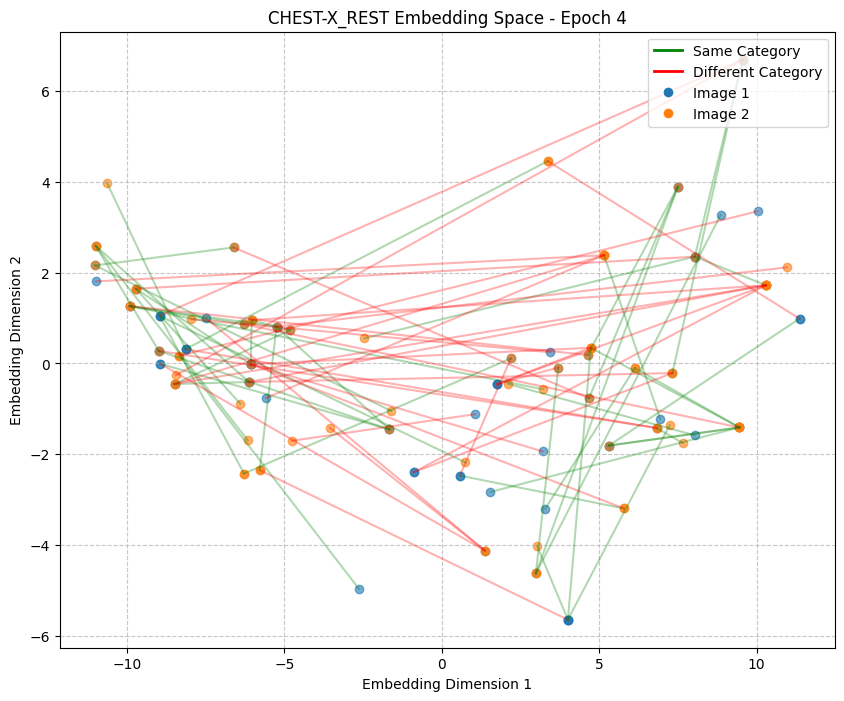

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 676ms/step - compute_contrastive_accuracy: 0.6420 - loss: 0.5565 - val_compute_contrastive_accuracy: 0.5375 - val_loss: 0.4773
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - compute_contrastive_accuracy: 0.7793 - loss: 0.5925Validation Set - Avg distance (same): 0.5784
Validation Set - Avg distance (diff): 0.7441
Distance gap: 0.1658


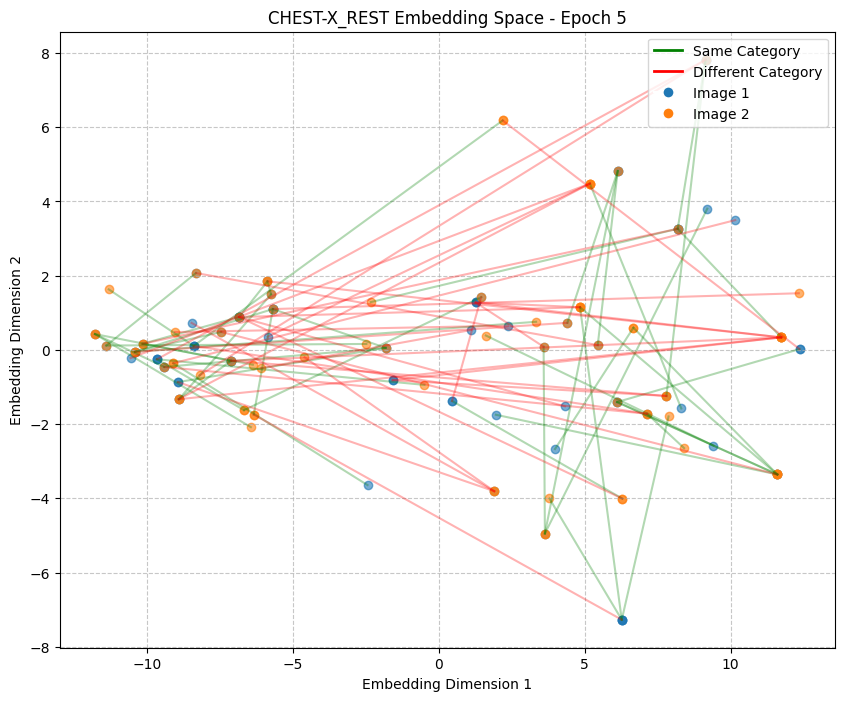

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - compute_contrastive_accuracy: 0.7743 - loss: 0.5927 - val_compute_contrastive_accuracy: 0.5625 - val_loss: 0.4914
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - compute_contrastive_accuracy: 0.7422 - loss: 0.5513

Validation Set - Avg distance (same): 0.5580
Validation Set - Avg distance (diff): 0.7463
Distance gap: 0.1883


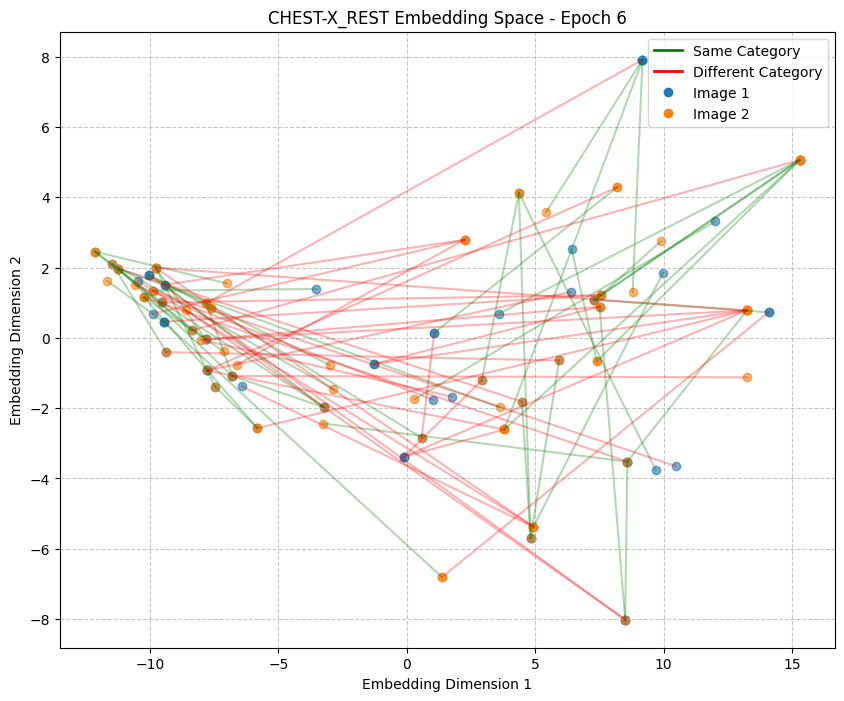

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 554ms/step - compute_contrastive_accuracy: 0.7434 - loss: 0.5490 - val_compute_contrastive_accuracy: 0.6500 - val_loss: 0.4621
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - compute_contrastive_accuracy: 0.7717 - loss: 0.5691Validation Set - Avg distance (same): 0.5344
Validation Set - Avg distance (diff): 0.6819
Distance gap: 0.1475


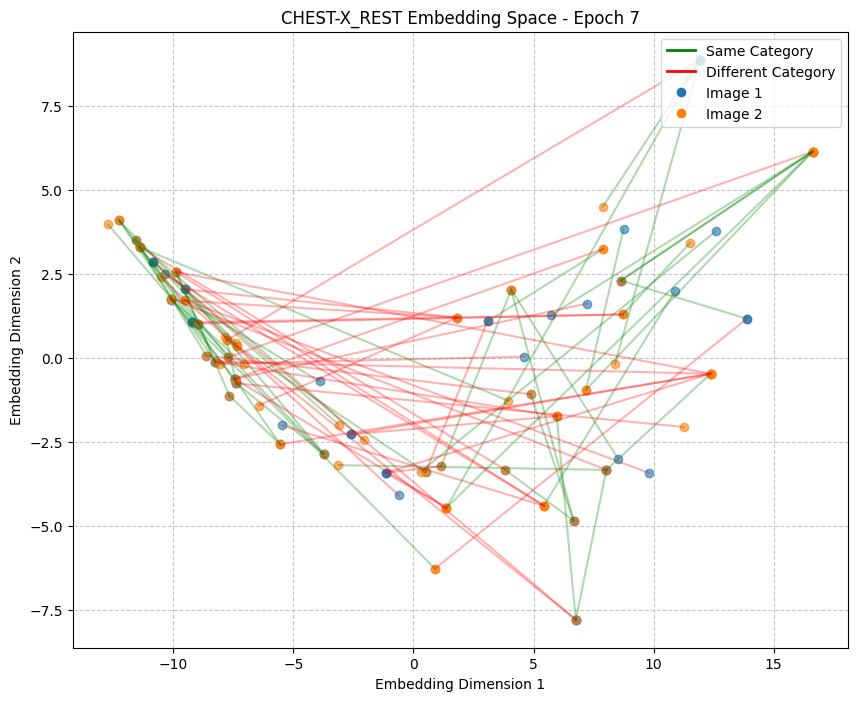

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step - compute_contrastive_accuracy: 0.7708 - loss: 0.5680 - val_compute_contrastive_accuracy: 0.6750 - val_loss: 0.4635
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - compute_contrastive_accuracy: 0.8123 - loss: 0.4978Validation Set - Avg distance (same): 0.4914
Validation Set - Avg distance (diff): 0.6664
Distance gap: 0.1751


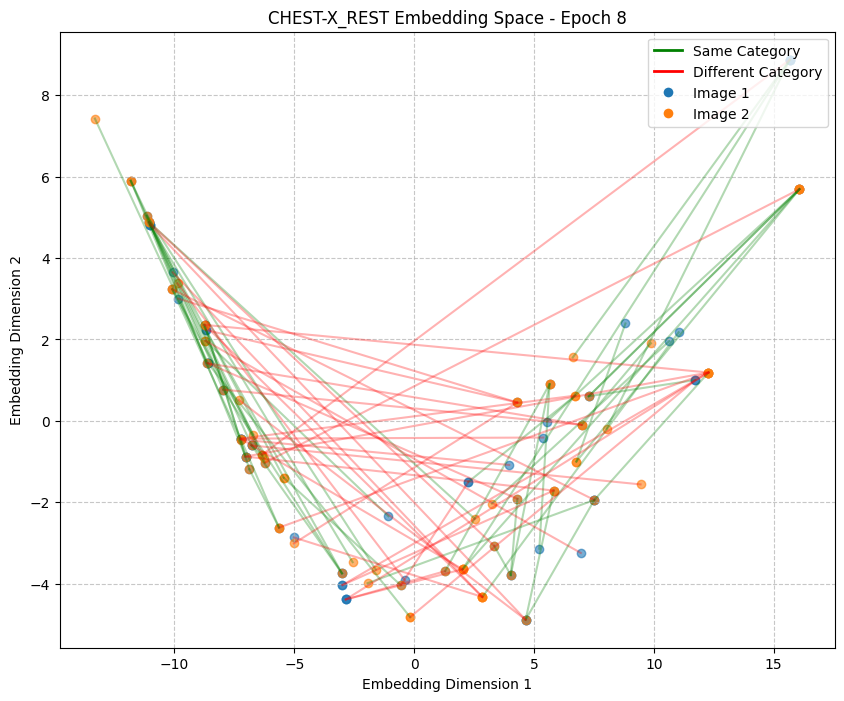

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - compute_contrastive_accuracy: 0.8095 - loss: 0.4990 - val_compute_contrastive_accuracy: 0.7875 - val_loss: 0.5174
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - compute_contrastive_accuracy: 0.8957 - loss: 0.5169Validation Set - Avg distance (same): 0.4800
Validation Set - Avg distance (diff): 0.6872
Distance gap: 0.2072


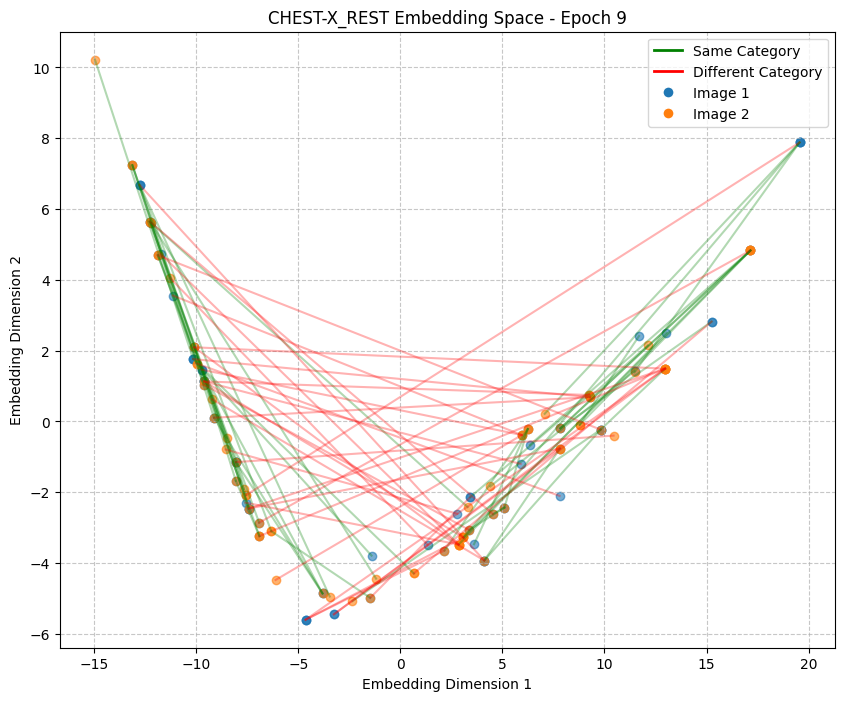

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 437ms/step - compute_contrastive_accuracy: 0.8944 - loss: 0.5163 - val_compute_contrastive_accuracy: 0.7875 - val_loss: 0.4727
Epoch 10/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - compute_contrastive_accuracy: 0.8896 - loss: 0.4370

Validation Set - Avg distance (same): 0.4834
Validation Set - Avg distance (diff): 0.7507
Distance gap: 0.2673


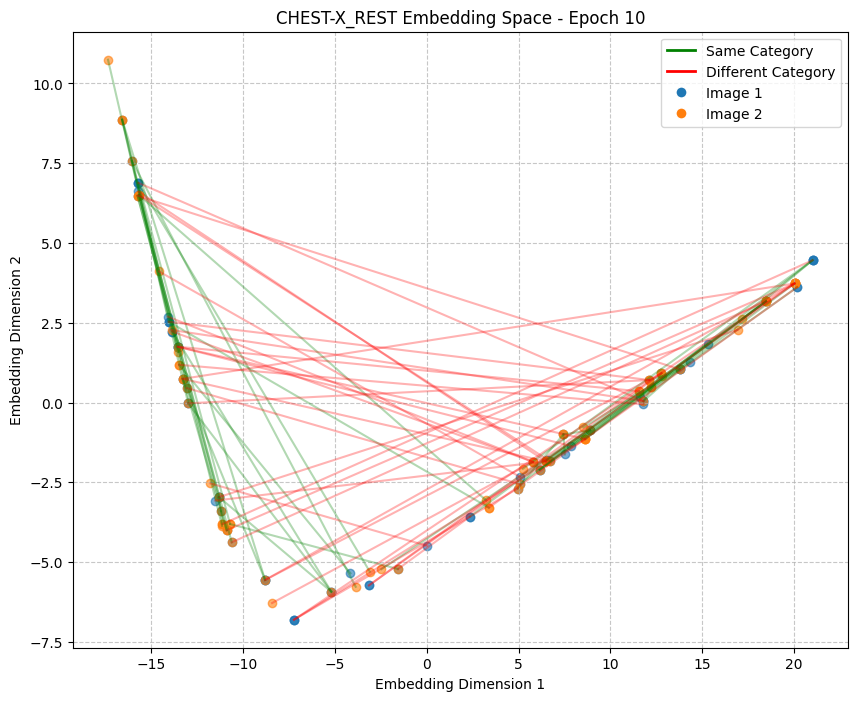

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - compute_contrastive_accuracy: 0.8877 - loss: 0.4396 - val_compute_contrastive_accuracy: 0.7750 - val_loss: 0.3998
Epoch 11/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - compute_contrastive_accuracy: 0.9553 - loss: 0.5156Validation Set - Avg distance (same): 0.4800
Validation Set - Avg distance (diff): 0.7241
Distance gap: 0.2441


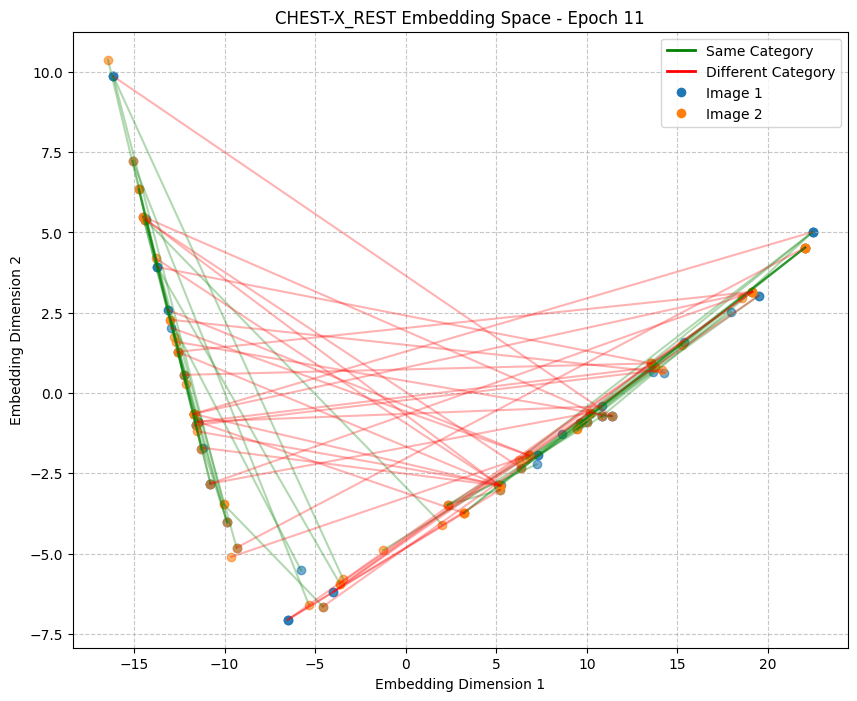

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - compute_contrastive_accuracy: 0.9531 - loss: 0.5137 - val_compute_contrastive_accuracy: 0.8750 - val_loss: 0.4310
Epoch 12/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - compute_contrastive_accuracy: 0.9288 - loss: 0.4708

Validation Set - Avg distance (same): 0.4692
Validation Set - Avg distance (diff): 0.7182
Distance gap: 0.2490


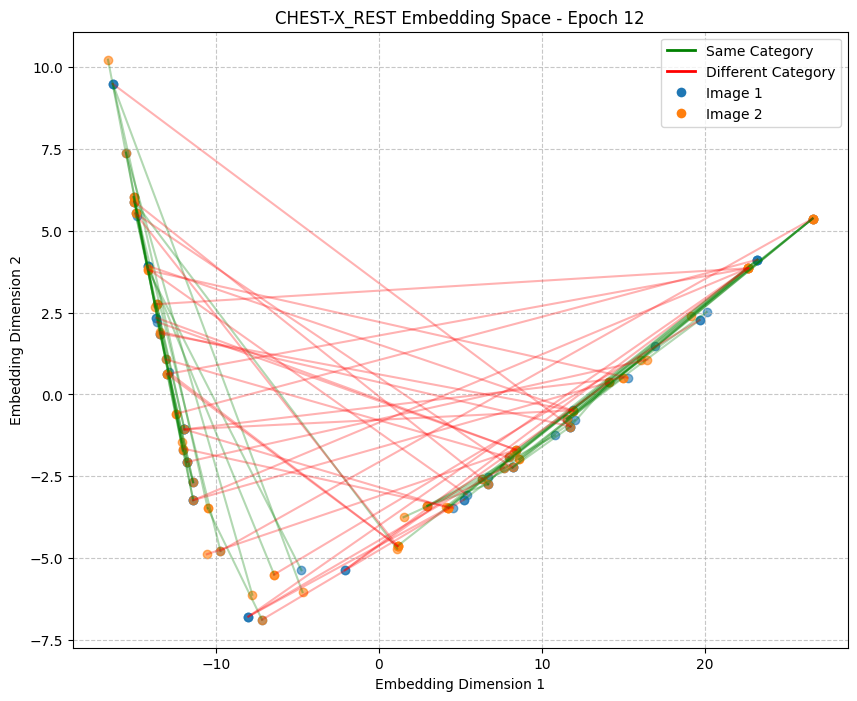

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 558ms/step - compute_contrastive_accuracy: 0.9296 - loss: 0.4719 - val_compute_contrastive_accuracy: 0.9125 - val_loss: 0.3871
Epoch 13/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - compute_contrastive_accuracy: 0.9057 - loss: 0.5214Validation Set - Avg distance (same): 0.4414
Validation Set - Avg distance (diff): 0.7520
Distance gap: 0.3106


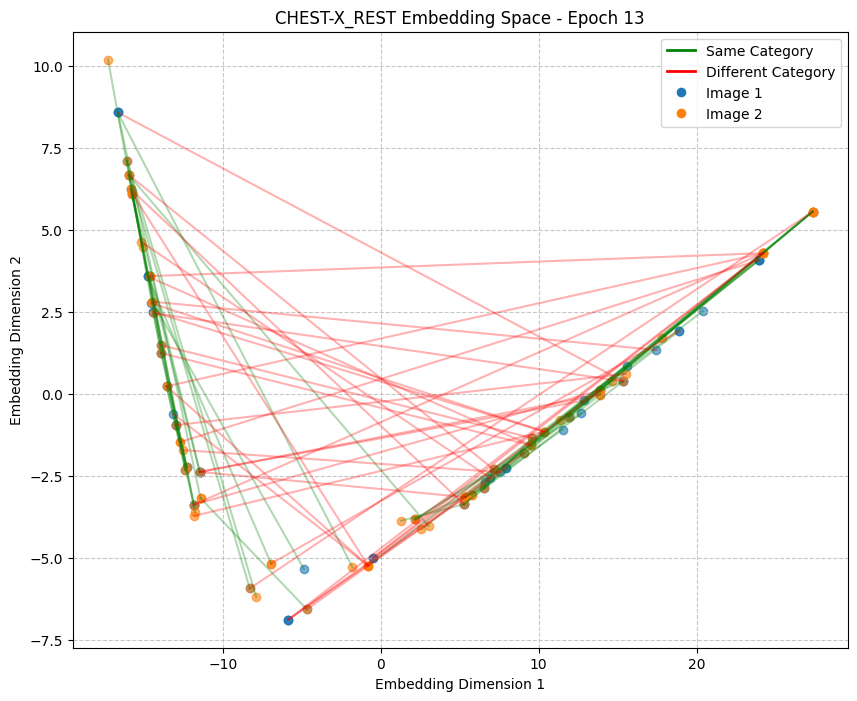

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 464ms/step - compute_contrastive_accuracy: 0.9057 - loss: 0.5196 - val_compute_contrastive_accuracy: 0.8375 - val_loss: 0.4456
Epoch 14/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - compute_contrastive_accuracy: 0.8370 - loss: 0.5666Validation Set - Avg distance (same): 0.4358
Validation Set - Avg distance (diff): 0.7086
Distance gap: 0.2728


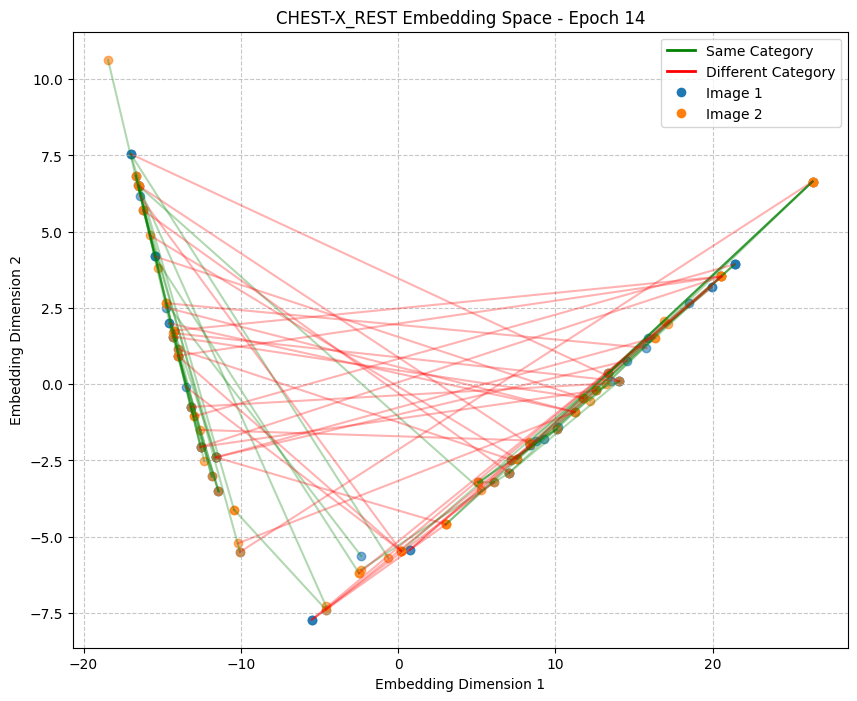

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - compute_contrastive_accuracy: 0.8410 - loss: 0.5614 - val_compute_contrastive_accuracy: 0.8375 - val_loss: 0.4885
Epoch 15/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - compute_contrastive_accuracy: 0.9352 - loss: 0.4779Validation Set - Avg distance (same): 0.4553
Validation Set - Avg distance (diff): 0.6753
Distance gap: 0.2200


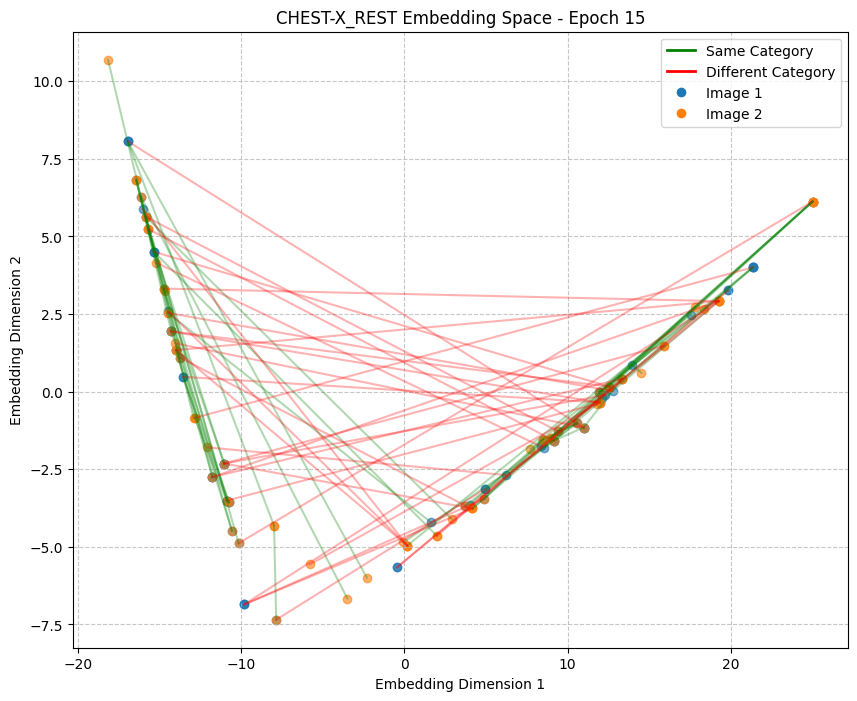

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 390ms/step - compute_contrastive_accuracy: 0.9360 - loss: 0.4761 - val_compute_contrastive_accuracy: 0.8250 - val_loss: 0.4278
Epoch 16/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - compute_contrastive_accuracy: 0.9446 - loss: 0.4951Validation Set - Avg distance (same): 0.3908
Validation Set - Avg distance (diff): 0.6527
Distance gap: 0.2619


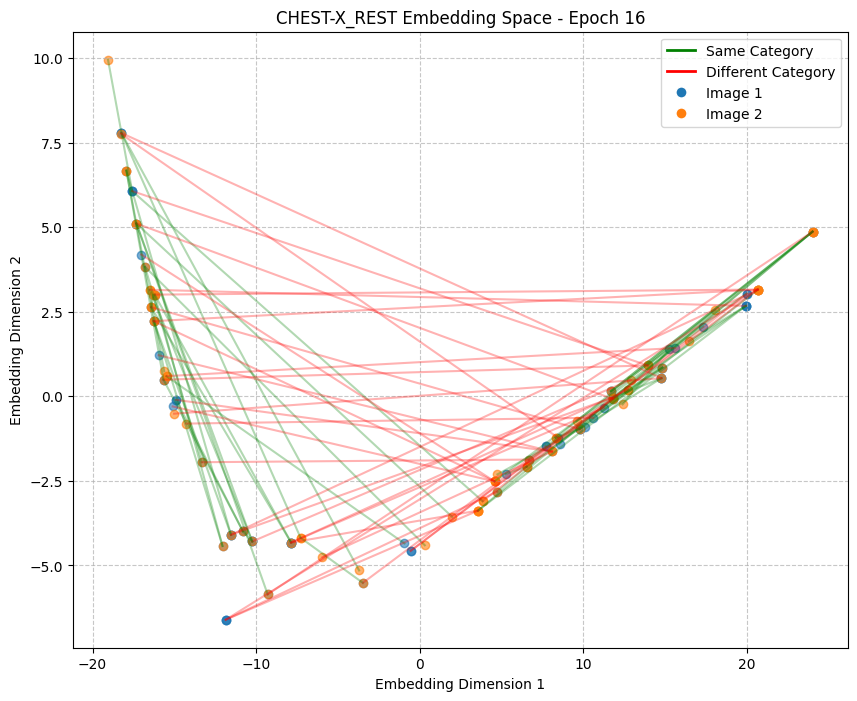

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 620ms/step - compute_contrastive_accuracy: 0.9405 - loss: 0.4962 - val_compute_contrastive_accuracy: 0.8500 - val_loss: 0.4674


In [ ]:
# Train the model
#siamse_network= siamese_model.h5
history = siamese_network.fit(
    train_gen,
    epochs=40,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

results on test

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import seaborn as sns


def evaluate_siamese_performance(model, data_generator, threshold=0.5):
    """Comprehensive evaluation of Siamese network performance"""
    # Get all distances and labels
    all_distances = []
    all_labels = []

    for i in range(len(data_generator)):
        (images_a, images_b), labels = data_generator[i]
        distances = model.predict([images_a, images_b], verbose=0).flatten()
        all_distances.extend(distances)
        all_labels.extend(labels)

    all_distances = np.array(all_distances)
    all_labels = np.array(all_labels)

    # Get similar and dissimilar distances
    similar_distances = all_distances[all_labels == 0]
    dissimilar_distances = all_distances[all_labels == 1]

    # Calculate basic statistics
    similar_mean = np.mean(similar_distances)
    similar_std = np.std(similar_distances)
    dissimilar_mean = np.mean(dissimilar_distances)
    dissimilar_std = np.std(dissimilar_distances)

    # Calculate ROC and PR curves
    fpr, tpr, thresholds_roc = roc_curve(all_labels, all_distances)
    roc_auc = auc(fpr, tpr)

    precision, recall, thresholds_pr = precision_recall_curve(all_labels, all_distances)
    pr_auc = average_precision_score(all_labels, all_distances)

    # Find optimal threshold using Youden's J statistic (maximizes tpr - fpr)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    optimal_threshold = thresholds_roc[best_idx]

    # Calculate predictions and accuracy with optimal threshold
    predictions = (all_distances > optimal_threshold).astype(int)
    accuracy = np.mean(predictions == all_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, predictions)

    results = {
        'similar_mean': similar_mean,
        'similar_std': similar_std,
        'dissimilar_mean': dissimilar_mean,
        'dissimilar_std': dissimilar_std,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'optimal_threshold': optimal_threshold,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'precision': precision,
        'recall': recall,
        'all_distances': all_distances,
        'all_labels': all_labels
    }

    return results

    # Evaluate on test set using the optimal threshold
print("\n--- Test Set Evaluation ---")
test_results = evaluate_siamese_performance(siamese_network, test_gen)

print(f"Test Results:")
print(f"Similar pairs - mean: {test_results['similar_mean']:.4f}, std: {test_results['similar_std']:.4f}")
print(f"Dissimilar pairs - mean: {test_results['dissimilar_mean']:.4f}, std: {test_results['dissimilar_std']:.4f}")
print(f"ROC AUC: {test_results['roc_auc']:.4f}")
print(f"PR AUC: {test_results['pr_auc']:.4f}")
print(f"Accuracy with optimal threshold: {test_results['accuracy']:.4f}")

# Enhanced visualization of results
plt.figure(figsize=(20, 15))



--- Test Set Evaluation ---
Test Results:
Similar pairs - mean: 0.4649, std: 0.1016
Dissimilar pairs - mean: 0.7088, std: 0.1149
ROC AUC: 0.9319
PR AUC: 0.9301
Accuracy with optimal threshold: 0.8906


<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

# cnn

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
data_dir = "/content/RSNA_dataset"
img_size = (150, 150)
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Training'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Validation'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Testing'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 160 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam

def build_model(input_shape=(150, 150, 3)):
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze model without 20 top layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    input = Input(shape=input_shape)
    x = base_model(input, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.53)(x)
    x = layers.Dense(128, activation="relu")(x)
    output = layers.Dense(1, activation="sigmoid")(x)  # פלט בינארי

    model = Model(input, output)
    model.compile(
        optimizer=Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model(input_shape=(150, 150, 3))
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5194 - loss: 0.8458

10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5245 - loss: 0.8368 - val_accuracy: 0.5000 - val_loss: 1.1683
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7471 - loss: 0.4959

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 540ms/step - accuracy: 0.7456 - loss: 0.4975 - val_accuracy: 0.5000 - val_loss: 1.1533
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7595 - loss: 0.5347

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 377ms/step - accuracy: 0.7592 - loss: 0.5335 - val_accuracy: 0.5125 - val_loss: 1.0745
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8746 - loss: 0.3487

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.8746 - loss: 0.3448 - val_accuracy: 0.5375 - val_loss: 0.9773
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9259 - loss: 0.2812

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - accuracy: 0.9247 - loss: 0.2822 - val_accuracy: 0.5625 - val_loss: 0.8572
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9123 - loss: 0.2210

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 443ms/step - accuracy: 0.9129 - loss: 0.2190 - val_accuracy: 0.5875 - val_loss: 0.7444
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9530 - loss: 0.1969

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.9521 - loss: 0.1997 - val_accuracy: 0.6375 - val_loss: 0.6530
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9485 - loss: 0.1582

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - accuracy: 0.9486 - loss: 0.1580 - val_accuracy: 0.6875 - val_loss: 0.5759
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9773 - loss: 0.1381

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 502ms/step - accuracy: 0.9771 - loss: 0.1367 - val_accuracy: 0.7625 - val_loss: 0.5021
Epoch 10/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9176 - loss: 0.1807

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - accuracy: 0.9205 - loss: 0.1774 - val_accuracy: 0.8125 - val_loss: 0.4489
Epoch 11/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9154 - loss: 0.1601

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step - accuracy: 0.9186 - loss: 0.1570 - val_accuracy: 0.8125 - val_loss: 0.4095
Epoch 12/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9729 - loss: 0.1171

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 559ms/step - accuracy: 0.9731 - loss: 0.1159 - val_accuracy: 0.8125 - val_loss: 0.3806
Epoch 13/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9808 - loss: 0.0899

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - accuracy: 0.9803 - loss: 0.0907 - val_accuracy: 0.8500 - val_loss: 0.3592
Epoch 14/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9671 - loss: 0.1029

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 383ms/step - accuracy: 0.9673 - loss: 0.1023 - val_accuracy: 0.8625 - val_loss: 0.3451
Epoch 15/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9817 - loss: 0.0655

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - accuracy: 0.9828 - loss: 0.0645 - val_accuracy: 0.8750 - val_loss: 0.3274
Epoch 16/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9541 - loss: 0.1139

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 411ms/step - accuracy: 0.9549 - loss: 0.1124 - val_accuracy: 0.8750 - val_loss: 0.3084
Epoch 17/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9866 - loss: 0.0841

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - accuracy: 0.9867 - loss: 0.0824 - val_accuracy: 0.8750 - val_loss: 0.3030
Epoch 18/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9708 - loss: 0.0806

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - accuracy: 0.9718 - loss: 0.0792 - val_accuracy: 0.8875 - val_loss: 0.2933
Epoch 19/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9850 - loss: 0.0407

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 507ms/step - accuracy: 0.9852 - loss: 0.0409 - val_accuracy: 0.8875 - val_loss: 0.2838
Epoch 20/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9932 - loss: 0.0521

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9932 - loss: 0.0522 - val_accuracy: 0.8875 - val_loss: 0.2741
Epoch 21/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9617 - loss: 0.0696

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.9629 - loss: 0.0697 - val_accuracy: 0.8875 - val_loss: 0.2698
Epoch 22/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 476ms/step - accuracy: 0.9784 - loss: 0.0570 - val_accuracy: 0.8875 - val_loss: 0.2864
Epoch 23/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.9711 - loss: 0.0588 - val_accuracy: 0.8750 - val_loss: 0.3055
Epoch 24/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - accuracy: 0.9946 - loss: 0.0434 - val_accuracy: 0.8750 - val_loss: 0.3007
Epoch 25/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - accuracy: 1.0000 - loss: 0.0221 - val_accuracy: 0.8875 - val_loss: 0.2893
Epoch 26/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.8875 - val_loss: 0.2778


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_binary_model(model, data_gen):
    y_true = []
    y_scores = []

    for batch_x, batch_y in data_gen:
        preds = model.predict(batch_x, verbose=0).flatten()
        y_scores.extend(preds)
        y_true.extend(batch_y)
        if len(y_true) >= data_gen.samples:
            break

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
    pr_auc = average_precision_score(y_true, y_scores)

    # optimal threshould
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    optimal_threshold = thresholds_roc[best_idx]

    y_pred = (y_scores > optimal_threshold).astype(int)
    acc = np.mean(y_pred == y_true)
    cm = confusion_matrix(y_true, y_pred)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # ROC
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # PR
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f"AP = {pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid()
    plt.legend()
    plt.show()

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


ROC AUC: 0.9513
PR AUC: 0.9644
Optimal Threshold: 0.2560
Accuracy: 0.9250
Confusion Matrix:
[[39  1]
 [ 5 35]]


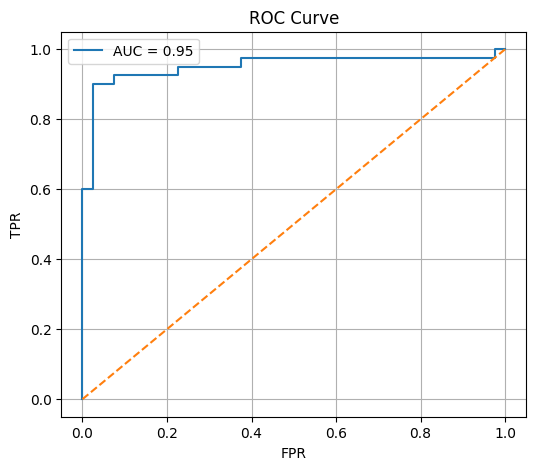

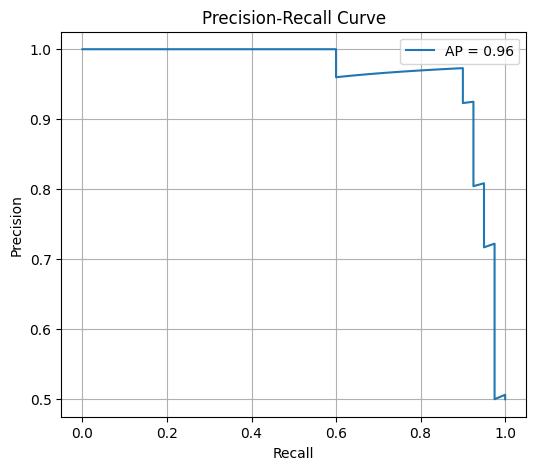

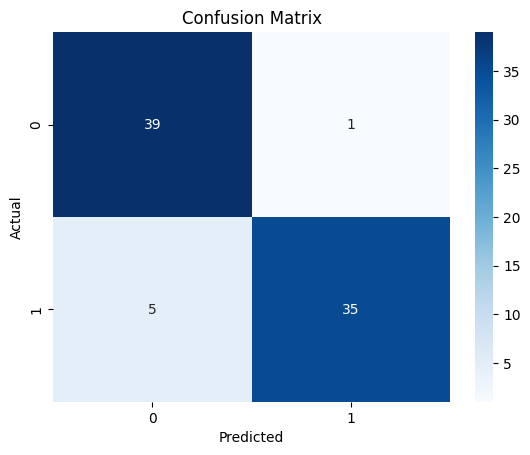

In [ ]:
evaluate_binary_model(model, test_gen)